Importación de bibliotecas

In [1]:
import os
import re
import tarfile
import zipfile
import pandas as pd
import numpy as np
import pickle
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import scipy
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
# Linear regression
from sklearn.linear_model import LogisticRegression

from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
# nltk.download('stopwords')

import mlflow
import mlflow.sklearn

Cambiar el workdir si se ejecuta el notebook localmente

In [2]:
os.chdir(r"C:\Users\aeveg\Documents\MASTERS\Proyecto\Proyecto de Materia\ProyectoDesarrolloSoluciones")

# Procesando los archivos del conjunto de datos

El conjunto de datos de reseñas de IMDB se encuentra constituido por una carpeta data que contiene dos carpetas, train y test, cada una con dos carpetas, pos y neg, que contienen 12500 archivos de texto con las reseñas de IMDB. Es necesario unificar estos archivos en un solo archivo CSV llamado imdb_reviews_train.csv y imdb_reviews_test.csv, respectivamente.

In [3]:
def leer_archivos_en_directorio(directorio, sentimiento):
    """
    Lee todos los archivos de texto en 'directorio' y devuelve una lista de diccionarios,
    cada uno con el texto, el sentimiento (pos/neg) y si es train o test.
    """
    registros = []
    for filename in os.listdir(directorio):
        if filename.endswith(".txt"):
            ruta_archivo = os.path.join(directorio, filename)
            with open(ruta_archivo, "r", encoding="utf-8") as f:
                texto = f.read()
            registros.append({
                "review": texto,
                "sentiment": sentimiento,  # 1 = positivo, 0 = negativo
                #"split": tipo              # 'train' o 'test'
            })
    return registros

# Leemos los archivos de cada carpeta
train_pos = leer_archivos_en_directorio("data/train/pos", sentimiento=1)
train_neg = leer_archivos_en_directorio("data/train/neg", sentimiento=0)
test_pos  = leer_archivos_en_directorio("data/test/pos",  sentimiento=1)
test_neg  = leer_archivos_en_directorio("data/test/neg",  sentimiento=0)

# Convertimos las listas de datos de train y test a un DataFrame de pandas
train_df = pd.DataFrame(train_pos + train_neg)
test_df = pd.DataFrame(test_pos + test_neg)

# Desordenamos aleatoriamente los DataFrames
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)


### Estructura de datos del conjunto de entrenamiento

#### Verificamos los datos al principio y al final del conjunto de datos de entrenamiento

In [4]:
print(train_df.head())
print(train_df.tail())
print("Total de reseñas de entrenamiento:", len(train_df))

                                              review  sentiment
0  In Panic In The Streets Richard Widmark plays ...          1
1  If you ask me the first one was really better ...          0
2  I am a big fan a Faerie Tale Theatre and I've ...          1
3  I just finished reading a book about Dillinger...          0
4  Greg Davis and Bryan Daly take some crazed sta...          0
                                                  review  sentiment
24995  My roommates & I nearly shorted out our TV fro...          0
24996  Michelle Rodriguez is the defining actress who...          1
24997  Nice movie with a great soundtrack which spans...          1
24998  Even though this was a made-for-TV production,...          0
24999  I saw this on cable recently and kinda enjoyed...          0
Total de reseñas de entrenamiento: 25000


#### Ver estructura de columnas y tipos de datos del conjunto de entrenamiento

In [5]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     25000 non-null  object
 1   sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
None


#### Estadísticas específicas para la columna "review" - Longitud promedio de reseña del conjunto de entrenamiento

In [6]:
train_df['word_count'] = train_df['review'].apply(lambda x: len(str(x).split()))
print("Longitud promedio de la reseña del conjunto de entrenamiento:", train_df['word_count'].mean(), "caracteres")

Longitud promedio de la reseña del conjunto de entrenamiento: 233.7872 caracteres


### Verificamos los datos al principio y al final del conjunto de datos de prueba

In [7]:
print(test_df.head())
print(test_df.tail())
print("Total de reseñas de prueba:", len(test_df))

                                              review  sentiment
0  When I was a kid, I loved "Tiny Toons". I espe...          1
1  The setup for "Nature of the Beast" is ingenio...          0
2  I do not have much to say than this is a great...          1
3  Extremely formulaic with cosmic-sized logic ho...          0
4  I actually liked certain things about this gam...          0
                                                  review  sentiment
24995  Start with the premise that you will do anythi...          0
24996  This movie gives us some WWII history along wi...          1
24997  In my opinion this is the best Oliver Stone fl...          1
24998  It's certainly a direct-to-video, but the stor...          0
24999  This movie was obscenely obvious and predictab...          0
Total de reseñas de prueba: 25000


#### Ver estructura de columnas y tipos de datos del conjunto de pruebas

In [8]:
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     25000 non-null  object
 1   sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
None


#### Estadísticas específicas para la columna "review" - Longitud promedio de reseña del conjunto de prueba

In [9]:
test_df['word_count'] = test_df['review'].apply(lambda x: len(str(x).split()))
print("Longitud promedio de la reseña del conjunto de pruebas:", test_df['word_count'].mean(), "caracteres")

Longitud promedio de la reseña del conjunto de pruebas: 228.52668 caracteres


Exportamos los conjuntos de entrenamiento y prueba a CSV (sin índice)

In [10]:
train_df.to_csv("data/imdb_reviews_train.csv", index=False, encoding="utf-8")
test_df.to_csv("data/imdb_reviews_test.csv", index=False, encoding="utf-8")

Obteniendo data de entrenamiento

In [11]:
def load_imdb_reviews(ruta_archivo):
    # Lee el archivo CSV y lo guarda en un DataFrame
    df = pd.read_csv(ruta_archivo)
    return df

In [12]:
df_train = load_imdb_reviews('./data/imdb_reviews_train.csv')
print("\nPrimeras 5 filas del conjunto de datos de entrenamiento de reseñas de IMDB en en español:")
df_train.head()


Primeras 5 filas del conjunto de datos de entrenamiento de reseñas de IMDB en en español:


,review,sentiment,word_count
0,In Panic In The Streets Richard Widmark plays ...,1,459
1,If you ask me the first one was really better ...,0,137
2,I am a big fan a Faerie Tale Theatre and I've ...,1,146
3,I just finished reading a book about Dillinger...,0,168
4,Greg Davis and Bryan Daly take some crazed sta...,0,142


Cargamos los datos de prueba

In [13]:
df_test = load_imdb_reviews('./data/imdb_reviews_test.csv')
print("\nPrimeras 5 filas del conjunto de datos de prueba de reseñas de IMDB en en español:")
df_test.head()


Primeras 5 filas del conjunto de datos de prueba de reseñas de IMDB en en español:


,review,sentiment,word_count
0,"When I was a kid, I loved ""Tiny Toons"". I espe...",1,120
1,"The setup for ""Nature of the Beast"" is ingenio...",0,217
2,I do not have much to say than this is a great...,1,285
3,Extremely formulaic with cosmic-sized logic ho...,0,183
4,I actually liked certain things about this gam...,0,173


In [14]:
print(df_train.iloc[18].review)
print(df_train.iloc[18].sentiment)

The best martial arts movie ever made. This one movie is better than anything Bruce Lee ever did. A classic with a thoroughly entertaining and brutal climax. Jackie Chan is the king of martial arts movies and the true king of kung fu.It's a great pity that whilst Bruce Lee had been so overrated, it took Jackie Chan an eternity to become popular in Europe and America. Jackie rules!!!!
1


In [15]:
def mostrar_distribucion_de_clases(df, stage):
    # Usando Seaborn para un gráfico de barras basado en el conteo de clases
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(x='sentiment', data=df, palette=['#FF9999','#99FF99'])

    ax.set_xticklabels(['Negativa', 'Positiva'])
    if stage == 'train':
        plt.title('Distribución de reseñas del conjunto de entrenamiento por clase de sentimiento')
    else:
        plt.title('Distribución de reseñas del conjunto de pruebas por clase de sentimiento')
    plt.xlabel('Clase de Sentimiento')
    plt.ylabel('Cantidad de Reseñas')
    plt.show()

C:\Users\aeveg\AppData\Local\Temp\ipykernel_9120\1866086346.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sentiment', data=df, palette=['#FF9999','#99FF99'])
C:\Users\aeveg\AppData\Local\Temp\ipykernel_9120\1866086346.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Negativa', 'Positiva'])


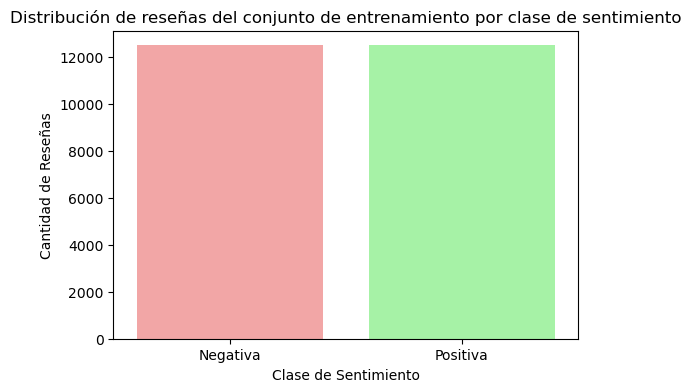

In [16]:
mostrar_distribucion_de_clases(df_train, 'train')

C:\Users\aeveg\AppData\Local\Temp\ipykernel_9120\1866086346.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sentiment', data=df, palette=['#FF9999','#99FF99'])
C:\Users\aeveg\AppData\Local\Temp\ipykernel_9120\1866086346.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Negativa', 'Positiva'])


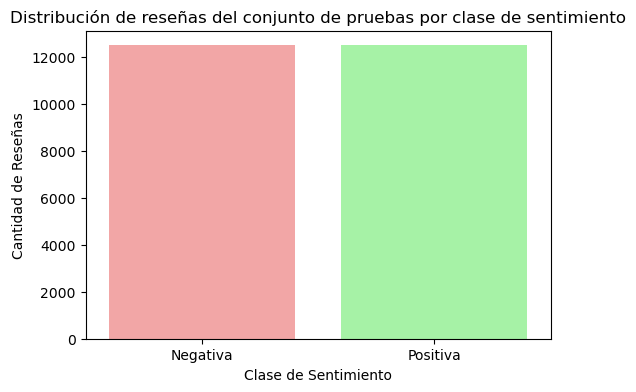

In [17]:
mostrar_distribucion_de_clases(df_test, 'test')

Imprimiendo 5 ejemplos de la clase negativa

In [18]:
for review in np.array(df_train)[np.array(df_train.sentiment) == 0][:5]:
    print(review)

['If you ask me the first one was really better one. Look at Sarah M. G., she is real, mean, cruel girl, look at Amy Adams she is just little fool hanging around. She is nothing! People don\'t adore her! Second, Sebastian was cute and hot in first movie, now he is "baby face". Story is not that good, and i do not understand. Why didn\'t they make this one first, it is the beginning. Loosy actors, nothing with story. This is not cruel, this is playing. First one has better actors, better story, and its mean. I think that the music is better in cruel intentions 1 and the music is better in cruel intentions 3. It is not the worst movie I saw, but in compaer with first one its one big, big, big nothing.'
 0 137]
["I just finished reading a book about Dillinger. This movie was horribly inaccurate. It's like they got a list of names and just made everything up. His robberies and getaways were well planned, down to the second - when the time was up, they left whether they had all of the money

Imprimiendo 5 ejemplos de la clase positiva

In [19]:
for review in np.array(df_train)[np.array(df_train.sentiment) == 1][:5]:
    print(review)

["In Panic In The Streets Richard Widmark plays U.S. Navy doctor who has his week rudely interrupted with a corpse that contains plague. As cop Paul Douglas properly points out the guy died from two bullets in the chest. That's not the issue here, the two of them become unwilling partners in an effort to find the killers and anyone else exposed to the disease.<br /><br />As was pointed out by any number of people, for some reason director Elia Kazan did not bother to cast the small parts with anyone that sounds like they're from Louisiana. Having been to New Orleans where the story takes place I can personally attest to that. Richard Widmark and his wife Barbara Bel Geddes can be excused because as a Navy doctor he could be assigned there, but for those that are natives it doesn't work.<br /><br />But with plague out there and the news being kept a secret, the New Orleans PD starts a dragnet of the city's underworld. The dead guy came off a ship from Europe and he had underworld connec

## Procesamiento de texto

Inicialmente crearemos una función para procesar y tokenizar el texto con las siguientes características:

* Transformar el texto a minúsculas.
* Eliminar caracteres que no sean letras. Para este problema de clasificación no parecen ser relevantes los caracteres puntuación, los números, ni caracteres especiales.
* Solo conservamos tokens que contengan dos o más letras.

In [20]:
def tokenize_text(text: str) -> "list[str]":
    """
    Procesa un texto y luego lo tokeniza.

    Args:
        text(str) texto a procesar y tokenizar.

    Returns:
        list[str] lista de tokens.
    """
    text = re.sub(r'[^a-z]', ' ', text.lower()) # Convertir a minúsculas y eliminar caracteres no alfabéticos
    text = re.sub(r'\s[a-z]([a-z])?\b', '', text) # Eliminar palabras de una o dos letras
    return text.split() # Tokenizar


sample = df_train.iloc[0].review
print('Texto original:')
print(sample)
print('Texto procesado y tokenizado:')
print(tokenize_text(sample))

Texto original:
In Panic In The Streets Richard Widmark plays U.S. Navy doctor who has his week rudely interrupted with a corpse that contains plague. As cop Paul Douglas properly points out the guy died from two bullets in the chest. That's not the issue here, the two of them become unwilling partners in an effort to find the killers and anyone else exposed to the disease.<br /><br />As was pointed out by any number of people, for some reason director Elia Kazan did not bother to cast the small parts with anyone that sounds like they're from Louisiana. Having been to New Orleans where the story takes place I can personally attest to that. Richard Widmark and his wife Barbara Bel Geddes can be excused because as a Navy doctor he could be assigned there, but for those that are natives it doesn't work.<br /><br />But with plague out there and the news being kept a secret, the New Orleans PD starts a dragnet of the city's underworld. The dead guy came off a ship from Europe and he had und

Podemos constuir el vocabulario de nuestro corpus de entrenamiento. Este tamaño sería el tamaño que tendría la representación de bolsa de palabras para cada uno de los documentos:

In [21]:
vocabulary = {}
for r in np.array(df_train):
    #print(r[0])
    for token in tokenize_text(r[0]):
        vocabulary[token] = vocabulary.get(token, 0) + 1

print(f'Número de tokens únicos: {len(vocabulary)}')

Número de tokens únicos: 72866


In [22]:
df_train.iloc[0]['review']

"In Panic In The Streets Richard Widmark plays U.S. Navy doctor who has his week rudely interrupted with a corpse that contains plague. As cop Paul Douglas properly points out the guy died from two bullets in the chest. That's not the issue here, the two of them become unwilling partners in an effort to find the killers and anyone else exposed to the disease.<br /><br />As was pointed out by any number of people, for some reason director Elia Kazan did not bother to cast the small parts with anyone that sounds like they're from Louisiana. Having been to New Orleans where the story takes place I can personally attest to that. Richard Widmark and his wife Barbara Bel Geddes can be excused because as a Navy doctor he could be assigned there, but for those that are natives it doesn't work.<br /><br />But with plague out there and the news being kept a secret, the New Orleans PD starts a dragnet of the city's underworld. The dead guy came off a ship from Europe and he had underworld connect

Ahora se definen un conjunto de palabras vacías (stopwords) en inglés, extraídas del módulo “stopwords” de NLTK. Estas palabras, como “the”, “and” o “if”, son generalmente eliminadas en tareas de procesamiento de texto dado que no suelen aportar valor semántico al análisis. Para ello, se transforma la lista en un objeto tipo “set” con el fin de agilizar las operaciones de verificación y filtrado de palabras.

A continuación, se instancia un objeto de la clase “WordCloud”, que recibe la opción “background_color” en “white” para establecer un fondo blanco y la lista de “stopwords” para evitar que aparezcan en la nube de palabras. Este objeto se genera a partir de la reseña que se encuentra en la primera fila de “df_train”, específicamente en la columna “review”. El método “generate” de la clase “WordCloud” construye la nube de palabras con base en la frecuencia de aparición de los términos en ese texto.

Finalmente, se despliega la nube de palabras resultante mediante la función “plt.imshow”, que muestra la imagen en el espacio de gráficos de Matplotlib. Se llama a “plt.axis("off")” para eliminar ejes y bordes que distraigan la visualización, y luego se ejecuta “plt.show()” para desplegar la figura en pantalla.

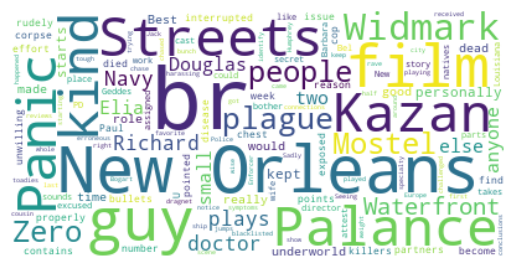

In [23]:
stop_words=set(stopwords.words('english'))
wordcloud = WordCloud(background_color="white",stopwords=stop_words).generate(df_train.iloc[0]['review'])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Podemos ver los tokens más frecuentes:

In [24]:
type(vocabulary.items())

dict_items

In [25]:
# Ver los 10 tokens más frecuentes
sorted(vocabulary.items(), key=lambda x: x[1], reverse=True)[:20]

[('the', 336758),
 ('and', 164143),
 ('this', 76007),
 ('that', 73287),
 ('was', 48209),
 ('for', 44345),
 ('with', 44130),
 ('movie', 44047),
 ('but', 42624),
 ('film', 40162),
 ('you', 34268),
 ('not', 30634),
 ('are', 29438),
 ('his', 29376),
 ('have', 27732),
 ('one', 26795),
 ('all', 23987),
 ('they', 22916),
 ('who', 21442),
 ('from', 20499)]

Estas tokens no parecen estar relacionados con el sentimiento de la reseña, por lo que podríamos eliminar los más frecuentes.

In [26]:
rare_tokens = [ (token, count) for token, count in vocabulary.items() if count < 2 ]
rare_tokens

[('toadies', 1),
 ('heft', 1),
 ('loosy', 1),
 ('compaer', 1),
 ('reactionaries', 1),
 ('enshrine', 1),
 ('changin', 1),
 ('acceptably', 1),
 ('talmadges', 1),
 ('yeast', 1),
 ('eardrums', 1),
 ('modulate', 1),
 ('eurselas', 1),
 ('sages', 1),
 ('worshipful', 1),
 ('gaptoothed', 1),
 ('cdn', 1),
 ('mindedly', 1),
 ('favortites', 1),
 ('meeuwsen', 1),
 ('abscessed', 1),
 ('saskatoon', 1),
 ('curvature', 1),
 ('popoff', 1),
 ('hinn', 1),
 ('appropriations', 1),
 ('blackmore', 1),
 ('ridd', 1),
 ('dugal', 1),
 ('doones', 1),
 ('ensor', 1),
 ('faggus', 1),
 ('briana', 1),
 ('evigan', 1),
 ('dewan', 1),
 ('seldana', 1),
 ('whiles', 1),
 ('mccombs', 1),
 ('viagem', 1),
 ('mindbender', 1),
 ('dioz', 1),
 ('croquet', 1),
 ('marriag', 1),
 ('workouts', 1),
 ('kibitz', 1),
 ('vidhu', 1),
 ('privleged', 1),
 ('q', 1),
 ('bearcats', 1),
 ('brisco', 1),
 ('coldblooded', 1),
 ('machinas', 1),
 ('concussive', 1),
 ('readjusted', 1),
 ('dater', 1),
 ('fawned', 1),
 ('unhelpful', 1),
 ('lechery', 1),
 

In [27]:
len(rare_tokens)

26910

Por otro lado los tokens menos frecuentes parecen ser nombres de películas, personajes, actores, entre otros, que tampoco parecen estar relacionados con la tarea de clasificación de sentimientos.

# 2. Uso de Lexicones

Adicionalmente a las representaciones de bolsa de palabras vistas en semanas anteriores. Podemos construir otro tipo de características que nosotros o expertos en el dominio de la tarea consideren relevantes para la solución del problema.

En el caso de análisis de sentimiento existen diferentes lexicones en los que podemos encontrar la connotación negativa o positiva de las palabras. En esta sección utilizaremos el **Lexico Afinn del usuario de github jboscomendoza** que puede descargarse [aquí](https://raw.githubusercontent.com/jboscomendoza/lexicos-nrc-afinn/refs/heads/master/lexico_afinn.csv).

Primero extraigamos los archivos correspondientes al lexicon descargado.

In [28]:
#lexicon = pd.read_csv('./data/lexico_afinn.csv')
#lexicon.head()

In [29]:
with open('data/subjclueslen1-HLTEMNLP05.tff') as f:
    lexicon = f.readlines()

for line in lexicon[:5]:
    print(line)

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative

type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative

type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative

type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative

type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative



Según la documentación del lexicon, se resaltan las siguientes características:

* palabra: Contiene la palabra en español.
* puntuacion: Contiene la puntuación de la palabra en español que corresponde a la polaridad de la palabra, ya sea negativa, positiva o neutral, representada por numeros enteros que pueden ser positivos negativos o cero y cuyo valor indica mayor o menor subjetividad en el contexto.
* word: Contiene la palabra en inglés.

Uno de los grupos más simples de características que podemos extraer sobre el texto es la cantidad de palabras negativas y positivas que contiene. Así que primero podemos almacener de una manera conveniente los sets de palabras negativas y positivas contenidas en el lexicón.

In [30]:
#negative_words = set()
#positive_words = set()

# Iteramos sobre las filas del lexicon
#for line in np.array(lexicon):
    # Extraemos la palabra y la polaridad de la línea
    #word = re.search(r'word1=(\w+)', line).group(1)
#    word = line[0]
#    polarity = line[1]
    # Guardamos la palabra en el conjunto correspondiente
#    if polarity <= 0:
#        negative_words.add(word)
#    else:
#print("Cantidad de palabras positivas:", len(positive_words))
#print("Cantidad de palabras negativas:", len(negative_words))
# Ver las primeras 10 palabras positivas
#print(f'10 palabras positivas: {list(positive_words)[:10]}')
# Ver las primeras 10 palabras negativas
#print(f'10 palabras negativas: {list(negative_words)[:10]}')

In [31]:
negative_words = set()
positive_words = set()

# Iteramos sobre las líneas del lexicon
for line in lexicon:
    # Extraemos la palabra y la polaridad de la línea
    word = re.search(r'word1=(\w+)', line).group(1)
    polarity = re.search(r'priorpolarity=(\w+)', line).group(1)
    # Guardamos la palabra en el conjunto correspondiente
    if polarity == 'negative':
        negative_words.add(word)
    if polarity == 'positive':
        positive_words.add(word)

print(f'Número de palabras positivas: {len(positive_words)}')
print(f'Número de palabras negativas: {len(negative_words)}')

# Ver las primeras 10 palabras positivas
print(f'10 palabras positivas: {list(positive_words)[:10]}')
# Ver las primeras 10 palabras negativas
print(f'10 palabras negativas: {list(negative_words)[:10]}')

Número de palabras positivas: 2267
Número de palabras negativas: 4103
10 palabras positivas: ['ingratiate', 'logical', 'understanding', 'assent', 'poise', 'togetherness', 'allay', 'positively', 'enviable', 'imaginative']
10 palabras negativas: ['wane', 'despondently', 'enemies', 'mercilessly', 'breach', 'scant', 'smouldering', 'upsettingly', 'barbarously', 'gawk']


Construyamos una clase similar a `CountVectorizer`de **scikit-learn** que nos permita extraer las características que definamos para cada documento del corpus.

En este ejemplo vamos a extraer únicamente el número de palabras positivas y negativas contenidas en cada documento según el lexicón que estamos usando.

In [32]:
class LexiconVectorizer:
    def __init__(self, positive_words: set, negative_words: set):
        """
        Este vectorizador cuenta la cantidad de palabras positivas y negativas en un texto según los sets de palabras positivas y negativas con que se inicialice.

        Args:
            positive_words(set[str]): conjunto de palabras positivas.
            negative_words(set[str]): conjunto de palabras negativas.
        """
        self.positive_words = positive_words
        self.negative_words = negative_words

    # Esta vectorizador no utiliza los datos de entrenamiento, por lo que el método fit solo retorna self
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Este método transforma una lista de textos en una matriz de numpy donde cada fila es la cantidad de palabras positivas y negativas en el texto correspondiente.

        Args:
            X(list[str]): lista de textos a transformar.

        Returns:
            np.array: matriz de numpy con la cantidad de palabras positivas y negativas en cada texto.
        """
        docs = []
        for doc in X:
            docs.append(self.count_words(doc))

        return np.array(docs)

    def count_words(self, text: str) -> "list[int]":
        """
        Este método cuenta la cantidad de palabras positivas y negativas en un texto.

        Args:
            text(str): texto a procesar.

        Returns:
            list[int]: lista con la cantidad de palabras positivas y negativas en el texto.
        """
        proccessed_text = tokenize_text(text)
        positive_count = sum([1 for word in proccessed_text if word in self.positive_words])
        negative_count = sum([1 for word in proccessed_text if word in self.negative_words])

        return [positive_count, negative_count]

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def __repr__(self) -> str:
        return "LexiconVectorizer()"

lexicon_vectorizer = LexiconVectorizer(positive_words, negative_words)
X_train_lexicon = lexicon_vectorizer.fit_transform(df_train["review"])
print('Representación vectorial de las primeras 5 reseñas:')
print(X_train_lexicon[:5])

Representación vectorial de las primeras 5 reseñas:
[[23 23]
 [17 16]
 [22  5]
 [10 11]
 [ 9  5]]


In [33]:
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(df_train["review"])
print('Representación vectorial de la primera reseña:')
X_train_bow[0]

Representación vectorial de la primera reseña:


<1x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 233 stored elements in Compressed Sparse Row format>

La representación de CountVectorizer consiste en una matriz dispersa de 462 dimensiones, con 240 dimensiones con un valor mayor a 0.

Nosotros también podemos crear una representación de texto personalizada en la que usemos la tradicional bolsa de palabras junto con las características extraídas de los lexicones.

In [34]:

class LexiconCountVectorizer(LexiconVectorizer):
    def __init__(self, positive_words: set, negative_words: set, *args, **kwargs):
        """
        Este vectorizador utiliza la representación generada por CountVectorizer junto con dos características sobre la proporción de palabras positivas y negativas identificadas en el documento.

        Args:
            positive_words(set[str]): conjunto de palabras positivas.
            negative_words(set[str]): conjunto de palabras negativas.
        """
        # Se inicializa la clase LexiconVectorizer
        super().__init__(positive_words, negative_words)
        # Se inicializa el CountVectorizer
        self.count_vect = CountVectorizer(*args, **kwargs)

    def fit(self, X, y=None):
        """
        Este método ajusta el vectorizador a los datos de entrenamiento.

        Args:
            X(list[str]): lista de textos de entrenamiento.
            y: no se utiliza.

        Returns:
            LexiconCountVectorizer: retorna el objeto actual.
        """
        # Se ajusta el CountVectorizer a los datos de entrenamiento
        self.count_vect.fit(X)
        return self

    def transform(self, X):
        """
        Este método transforma una lista de textos en una matriz de numpy donde cada fila contiene las características extraídas de cada documento.

        Args:
            X(list[str]): lista de textos a transformar.

        Returns:
            np.array: matriz de numpy con la representación vectorial de cada documento.
        """
        # Generar la representación de bolsa de palabras de los documentos
        bow = self.count_vect.transform(X)

        # Generar las características de palabras positivas y negativas de los documentos
        lexicon_features = []
        for doc in X:
            lexicon_features.append(self.count_words(doc))

        # Se cálcula la proporción de palabras positivas y negativas en cada documento
        lexicon_features = np.array(lexicon_features) / (np.sum(lexicon_features, axis=1).reshape(-1, 1) + 0.01) # Se suma 0.01 para evitar divisiones por cero
        # Se convierte a una matriz dispersa del mismo tipo que la matriz de bolsa de palabras
        lexicon_features = scipy.sparse.csr_matrix(lexicon_features)

        # Se concatenan las características de bolsa de palabras y las características de palabras positivas y negativas
        return scipy.sparse.hstack([lexicon_features, bow], format='csr')

    # set_params es un método utilizado por GridSearchCV para ajustar los parámetros del vectorizador
    def set_params(self, **params):
        """
        Este método ajusta los parámetros del CountVectorizer.

        Args:
            **params: parámetros a ajustar.

        Returns:
            LexiconCountVectorizer: retorna el objeto actual.
        """
        self.count_vect.set_params(**params)
        return self

    def __repr__(self) -> str:
        return "LexiconCountVectorizer()"

# Prueba del vectorizador
bow_vectorizer = LexiconCountVectorizer(positive_words, negative_words)
X_train_bow = bow_vectorizer.fit_transform(df_train["review"])
print('Representación vectorial de la primera reseña:')
X_train_bow[0]

Representación vectorial de la primera reseña:


<1x74851 sparse matrix of type '<class 'numpy.float64'>'
	with 235 stored elements in Compressed Sparse Row format>

Note como el resultado del vectorizador para la primera reseña tiene 2 dimensiones más que la representación de bolsa de palabras realizada en la celda anterior con `CountVectorizer`, y además la matriz dispersa contiene ahora 94 valores mayores a 0 en vez de 92.

Ahora observe los valores contenidos en la representación vectorial del primer documento del corpus:

In [35]:
print(X_train_bow[0])

  (0, 0)	0.49989132797218
  (0, 1)	0.49989132797218
  (0, 1279)	1.0
  (0, 1630)	1.0
  (0, 2150)	1.0
  (0, 2823)	1.0
  (0, 3169)	3.0
  (0, 3260)	9.0
  (0, 3705)	2.0
  (0, 3717)	2.0
  (0, 4126)	4.0
  (0, 4299)	1.0
  (0, 4467)	3.0
  (0, 4639)	1.0
  (0, 4660)	1.0
  (0, 4755)	1.0
  (0, 4894)	1.0
  (0, 5918)	1.0
  (0, 6336)	4.0
  (0, 6461)	2.0
  (0, 6484)	1.0
  (0, 6545)	1.0
  (0, 6581)	1.0
  (0, 6665)	2.0
  (0, 6684)	1.0
  :	:
  (0, 68771)	2.0
  (0, 69435)	2.0
  (0, 70308)	1.0
  (0, 70333)	1.0
  (0, 70507)	1.0
  (0, 70508)	1.0
  (0, 71161)	2.0
  (0, 72198)	5.0
  (0, 72283)	3.0
  (0, 72454)	1.0
  (0, 72499)	1.0
  (0, 72755)	1.0
  (0, 72759)	3.0
  (0, 72906)	4.0
  (0, 72913)	1.0
  (0, 72967)	1.0
  (0, 73006)	3.0
  (0, 73030)	1.0
  (0, 73289)	1.0
  (0, 73344)	6.0
  (0, 73493)	1.0
  (0, 73618)	1.0
  (0, 73716)	2.0
  (0, 74149)	1.0
  (0, 74611)	3.0


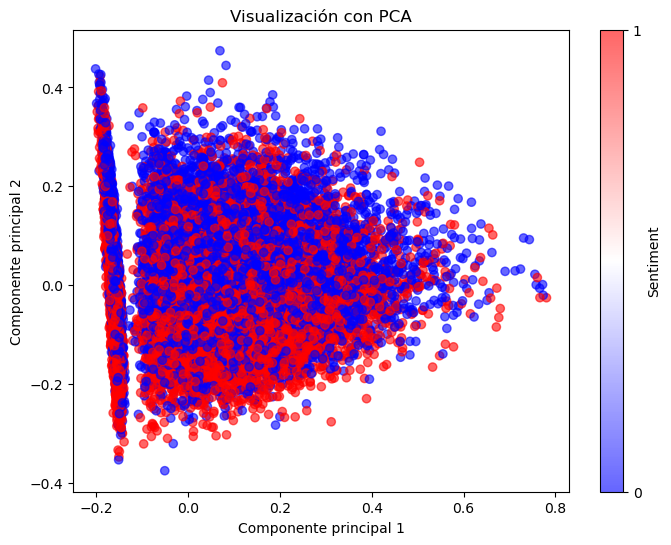

In [36]:
# 1. Principal component analysis.  …Usamos TfidfVectorizer con max_features=1000 para evitar la sobrecarga en memoria.
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_bow = vectorizer.fit_transform(df_train['review'])
X = X_train_bow.toarray()

# 2. Reducción de dimensionalidad con PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# 3. Visualización en 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], 
                      X_pca[:, 1], 
                      c=df_train['sentiment'], 
                      cmap='bwr',   # bwr = blue-white-red
                      alpha=0.6)
plt.colorbar(scatter, ticks=[0, 1], label='Sentiment')
plt.title("Visualización con PCA")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.show()

# 3. Entrenamiento de clasificadores de texto

En esta sección usaremos los clasificadores de **regresión logística** y **naive bayes** para clasificar el sentimiento de nuestras reseñas de películas. Vamos a probar distintas representaciones de texto para encontrar el modelo que mejor se ajusta a nuestro problema. Para realizar estas pruebas de manera conveniente vamos a utilizar `GridSearch` que nos permite poner a prueba el desempeño de distintos pipelines, y distintos hiperparámetros. Adicionalmente `GridSearch` utiliza validación cruzada para medir el desempeño de los modelos de una manera más robusta.

Consulte la siguiente guía para conocer otras técnicas de ajuste de hiperparámetros, y para entender mejor su funcionamiento. [Link a la guía](https://scikit-learn.org/stable/modules/grid_search.html#tips-for-parameter-search).

**Advertencia**: La ejecución de esta celda puede tardar más de 30 minutos.

In [37]:
list_train_reviews = list(df_train["review"])
list_train_labels = list(df_train["sentiment"])

In [39]:
# Configurar MLflow
mlflow.set_tracking_uri('http://localhost:5000')
experiment = mlflow.set_experiment("sklearn-text-classification")

2025/03/10 00:14:55 INFO mlflow.tracking.fluent: Experiment with name 'sklearn-text-classification' does not exist. Creating a new experiment.


In [40]:
# Preparar los datos de entrenamiento
list_train_reviews = list(df_train["review"])
list_train_labels = list(df_train["sentiment"])

In [41]:
# Definir el pipeline con un vectorizador y un clasificador
pipeline = Pipeline([
    ('representation', CountVectorizer()),
    ('classifier', LogisticRegression())
])

# Definir el espacio de búsqueda de hiperparámetros
param_grid = [
    {
        'representation': [CountVectorizer(), TfidfVectorizer(), LexiconCountVectorizer(positive_words, negative_words)],
        'representation__max_df': [0.8, 0.9, 1.0],
        'representation__min_df': [0.1, 0.5, 1],
        'classifier': [MultinomialNB(), LogisticRegression(max_iter=1000)]
    }
]

# Iniciar la ejecución principal del experimento
with mlflow.start_run(experiment_id=experiment.experiment_id) as parent_run:
    # Ejecutar GridSearchCV
    search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    search.fit(list_train_reviews, list_train_labels)
    
    # Registrar el mejor modelo
    best_params = search.best_params_
    best_score = search.best_score_
    mlflow.log_param("best_params", str(best_params))
    mlflow.log_metric("best_cv_accuracy", best_score)
    mlflow.sklearn.log_model(search.best_estimator_, "best-model")
    
    # Registrar cada configuración evaluada como una sub-ejecución
    cv_results = search.cv_results_
    for i, params in enumerate(cv_results["params"]):
        with mlflow.start_run(nested=True):
            mlflow.set_tag("grid_search_index", i)
            mlflow.log_params(params)
            mlflow.log_metric("mean_test_score", cv_results["mean_test_score"][i])
            mlflow.log_metric("std_test_score", cv_results["std_test_score"][i])
    
    # (Opcional) Registrar todos los resultados en un CSV como artefacto
    results_df = pd.DataFrame(cv_results)
    results_df.to_csv("cv_results.csv", index=False)
    mlflow.log_artifact("cv_results.csv")
    
    print("Mejor configuración:\n{}\n".format(best_params))
    print("Mejor puntaje de validación cruzada: {:.2f}".format(best_score))

2025/03/10 00:22:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run rumbling-moose-539 at: http://localhost:5000/#/experiments/467765586855792001/runs/428e0dd42b4c4f5195cdc923a3bb21db
🧪 View experiment at: http://localhost:5000/#/experiments/467765586855792001
🏃 View run big-dog-794 at: http://localhost:5000/#/experiments/467765586855792001/runs/3d883de4557c4139bdc649ba101d41ec
🧪 View experiment at: http://localhost:5000/#/experiments/467765586855792001
🏃 View run useful-crab-750 at: http://localhost:5000/#/experiments/467765586855792001/runs/1316d5608ee742b58ec8beef36e26ec4
🧪 View experiment at: http://localhost:5000/#/experiments/467765586855792001
🏃 View run intrigued-doe-70 at: http://localhost:5000/#/experiments/467765586855792001/runs/2b27c0a9ca034ff5ae3c4519b5a3bf49
🧪 View experiment at: http://localhost:5000/#/experiments/467765586855792001
🏃 View run luxuriant-newt-824 at: http://localhost:5000/#/experiments/467765586855792001/runs/7a1fd97260e84306a541fa736fe45fc8
🧪 View experiment at: http://localhost:5000/#/experiments/46776558685

In [42]:
# Guardar el mejor modelo en un directorio local
mlflow.sklearn.save_model(search.best_estimator_, "model_export")

La busqueda de hiperparámetros nos indica que la configuración que mejor resultados en promedio obtuvo fue la representación generada por `TfidfVectorizer`, en la que se utilizan todas las palabras del vocabulario ('representation__max_df': 1.0, y 'representation__min_df': 0) con un clasificador de regresión logística. En promedio esta configuración obtuvo un 89% de accuracy en las 5 particiones de evaluación generadas.

Adicionalmente, la clase `GridSearchCV` posee el atributo `cv_results_` en donde podemos ver todos los resultados obtenidos para cada configuración probada. Este diccionario puede leerse fácilmente como un `DataFrame` de **pandas**, y darnos información importante como la duración del entrenamiento (en segundos), los parámetros probados en la configuración, y los puntajes obtenidos de entrenamiento y de evaluación por cada uno de las particiones realizadas de los datos.

In [43]:
# Mostramos los resultados de la búsqueda de hiperparámetros ordenados por el puntaje de validación cruzada promedio de mayor a menor
df_results = pd.DataFrame(search.cv_results_)
df_results.sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_representation,param_representation__max_df,param_representation__min_df,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
41,9.615997,0.169027,4.167797,0.214943,LogisticRegression(max_iter=1000),TfidfVectorizer(),0.9,1.0,{'classifier': LogisticRegression(max_iter=100...,0.888409,0.881675,0.887315,0.88580,0.002951,1
38,10.603157,0.269241,4.599348,0.407342,LogisticRegression(max_iter=1000),TfidfVectorizer(),0.8,1.0,{'classifier': LogisticRegression(max_iter=100...,0.885289,0.881075,0.888276,0.88488,0.002954,2
44,9.425294,0.077990,3.889515,0.062426,LogisticRegression(max_iter=1000),TfidfVectorizer(),1.0,1.0,{'classifier': LogisticRegression(max_iter=100...,0.886369,0.879035,0.888276,0.88456,0.003983,3
53,32.648198,0.959180,5.344275,0.219627,LogisticRegression(max_iter=1000),LexiconCountVectorizer(),1.0,1.0,{'classifier': LogisticRegression(max_iter=100...,0.876770,0.874955,0.877835,0.87652,0.001189,4
50,31.080581,1.274509,7.163339,0.255893,LogisticRegression(max_iter=1000),LexiconCountVectorizer(),0.9,1.0,{'classifier': LogisticRegression(max_iter=100...,0.876890,0.875435,0.876875,0.87640,0.000682,5
35,24.769175,1.682731,3.953733,0.188299,LogisticRegression(max_iter=1000),CountVectorizer(),1.0,1.0,{'classifier': LogisticRegression(max_iter=100...,0.877010,0.874955,0.877115,0.87636,0.000994,6
47,29.279366,0.959889,7.102929,0.245364,LogisticRegression(max_iter=1000),LexiconCountVectorizer(),0.8,1.0,{'classifier': LogisticRegression(max_iter=100...,0.877010,0.875195,0.876635,0.87628,0.000782,7
32,21.690942,1.580331,4.705516,0.453644,LogisticRegression(max_iter=1000),CountVectorizer(),0.9,1.0,{'classifier': LogisticRegression(max_iter=100...,0.877130,0.874595,0.876755,0.87616,0.001117,8
29,21.847455,1.865269,4.714433,0.285109,LogisticRegression(max_iter=1000),CountVectorizer(),0.8,1.0,{'classifier': LogisticRegression(max_iter=100...,0.876050,0.873395,0.877355,0.87560,0.001648,9
11,10.241839,0.407244,4.836163,0.229534,MultinomialNB(),TfidfVectorizer(),0.8,1.0,"{'classifier': MultinomialNB(), 'representatio...",0.858171,0.859594,0.867275,0.86168,0.003998,10


En la tabla anterior se evidencia que en general los modelos de Regresión Logística obtienen un mejor desemepeño que los modelos de Naive Bayes. También se observa que en general las mejores representaciones de texto son `TfidfVectorizer`, `LexiconCountVectorizer`, `CountVectorizer`, y `LexiconVectorizer` en el orden correspondiente, y finalmente se observa que para los vectorizadores los mejores hiperpárametros son utilizar todas las palabras presentes en el corpus a excepción de aquellas con una única ocurrencia.

# 4. Evaluación de los clasificadores

Finalmente, hacemos uso del set de evaluación para validar el desempeño de nuestro modelo.

En primer lugar, utilizando el conjunto de datos de pruebas, calculamos el accuracy del modelo con mejor desempeño:

In [44]:
search.best_estimator_.score(df_test["review"], df_test["sentiment"])

0.8854

También podemos ver la matriz de confusión generada por nuestro modelo en el set evaluación:

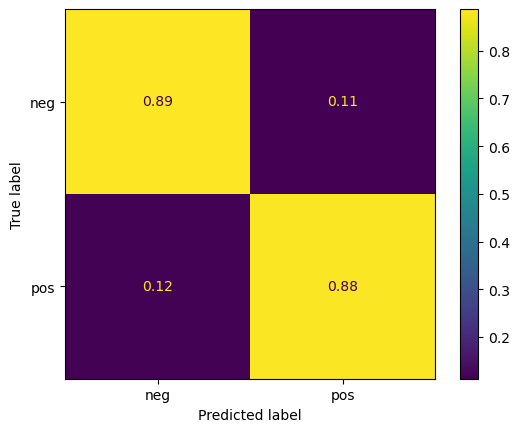

In [45]:
# Realizamos la predicción sobre el conjunto de prueba
y_pred = search.best_estimator_.predict(df_test["review"])

# Construimos la matriz de confusión
conf_mtx = confusion_matrix(df_test["sentiment"], y_pred, normalize='true')

# Mostramos la matriz de confusión
disp = ConfusionMatrixDisplay(conf_mtx, display_labels=["neg","pos"])
disp.plot()
plt.show()

Otras métricas que pueder ser relevantes según el problema son el `f1-score`, la precisión, y la sensitividad, ya sean macro o micro:

In [46]:
print(classification_report(df_test["sentiment"], y_pred, target_names=["neg", "pos"]))

              precision    recall  f1-score   support

         neg       0.88      0.89      0.89     12500
         pos       0.89      0.88      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



Veamos ejemplos de clasificación de nuestro modelo:

In [47]:
pos_example = "I loved this movie, it was amazing!"
neg_example = "I hated this movie, it was terrible!"

print(f'Ejemplo positivo: {search.best_estimator_.predict([pos_example])[0]}')
print(f'Ejemplo negativo: {search.best_estimator_.predict([neg_example])[0]}')

Ejemplo positivo: 1
Ejemplo negativo: 0
